# Trying to predict number of COVID-19 tests by August 1st 2020
*Notebook by Steven Rybicki*

In this notebook, we'll be focusing on trying to predict the number of COVID-19 tests in the US. Namely, we'll be looking at forecasting the answer to:
> By August 1, how many tests for COVID-19 will have been administered in the US?

taken from the [Metaculus question](https://pandemic.metaculus.com/questions/4400/by-august-1-how-many-tests-for-covid-19-will-have-been-administered-in-the-us/). This just looks at number of tests, not distinguishing by type or if someone is tested multiple times.

To do this, we're going to be using [ergo](https://github.com/oughtinc/ergo), a library by [Ought](https://ought.org/). This lets you integrate model based forecasting (building up a numerical model to predict outcomes) with judgement based forecasting (using calibration to try predict outcomes less formally). To see other notebooks using ergo, see [the ergo repo](https://github.com/oughtinc/ergo/tree/master/notebooks). 

I'll be trying to walk through how you'd use this realistically if you wanted to forecast the answer to a question without spending a ton of time on it. This means our model will be kind of rough, but hopefully accurate-ish, and I'll be iteratively trying to improve it as we go along. 

# Notebook setup

This imports libraries, and sets up some useful functions

In [56]:
%%capture
!pip install --progress-bar off poetry
!pip install --progress-bar off git+https://github.com/oughtinc/ergo.git@e9f6463de652f4e15d7c9ab0bb9f067fef8847f7

In [57]:
import warnings
import ssl
warnings.filterwarnings(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="plotnine")
ssl._create_default_https_context = ssl._create_unverified_context

In [58]:
import ergo
import seaborn

import numpy as np
import pandas as pd
from datetime import timedelta, date, datetime
import matplotlib.pyplot as plt

pd.set_option('precision', 2)

# Copy some useful functions from the `el-paso-workflow.ipynb` for plotting, and some imports
def summarize_samples(samples):
    """
    Print out the p5, p50 and p95 of the given sample
    """
    stats = samples.describe(percentiles=[0.05, 0.5, 0.95])
    percentile = lambda pt: float(stats.loc[f"{pt}%"])
    return f"{percentile(50):.2f} ({percentile(5):.2f} to {percentile(95):.2f})"

def show_marginal(func):
    """
    Use ergo to generate 1000 samples of the distribution of func, and then plot them as a distribution. 
    """
    samples = ergo.run(func, num_samples=1000)["output"]
    seaborn.distplot(samples).set_title(func.__doc__);
    plt.show()
    print(f"Median {func.__doc__}: {summarize_samples(samples)}")

# How are we going to predict this?

## Principles

Here's a couple things we're going to try to do when predicting this:

- *fermi estimate / decomposition*: focus on decomposing the question into multiple parts that we can estimate separately. We'll start with our overall question (how many tests) and decompose it into smaller questions that are easier to predict (e.g. what's the estimated number of tests we will make tomorrow?)
- *use live date*: where possible, fetch live data. This lets us easily update our guess, as we can just rerun the notebook and it will update our prediction based on updated data. 
- *wisdom of the crowds*: incorporate other predictions, namely the [Metaculus one](https://pandemic.metaculus.com/questions/4400/by-august-1-how-many-tests-for-covid-19-will-have-been-administered-in-the-us/), so we can include information we might have missed.

## Question decomposition

Let's decompose our question into a number of sub questions. We'll then focus on trying to estimate each of these separately, allowing us to iteratively improve our model as we go along.

So the number of tests done by August 1st could be decomposed as:
 - ensemble prediction of:
     - my prediction
        - current number of tests: how many tests did we do today?
        - how much we can expect to change until August 1st?
            - if we repeat our current rates, how does it look in August?
            - how much we can we expect our testing rates to change based on the past results?
            - how much can we expect our testing rates to change, based on future factors?
     - metaculus question 

# My Prediction

## Get relevant data

To know the current testing rate, and and how it changes, we're going to use the https://covidtracking.com/ API to fetch the testing statistics. To make it easier to parse, we're going to filter to the fields we care about:
- date
- totalTestResults: culmulative tests per day
- totalTestReusltsIncrease: how many new test results were reported that day

In [59]:
testing_data = pd.read_csv("https://covidtracking.com/api/v1/us/daily.csv")
# testing data uses numbers for dates (20200531 for e.g.), so let's convert that to use python dates instead
testing_data["date"] = testing_data["date"].apply(lambda d: datetime.strptime(str(d),  "%Y%m%d"))

# now filter just to the columns we care about
testing_data = testing_data[["date", "totalTestResults", "totalTestResultsIncrease"]]
testing_data

,date,totalTestResults,totalTestResultsIncrease
0,2020-05-31,16936891,406206.0
1,2020-05-30,16530685,431170.0
2,2020-05-29,16099515,492276.0
3,2020-05-28,15607239,414758.0
4,2020-05-27,15192481,285440.0
...,...,...,...
126,2020-01-26,1,0.0
127,2020-01-25,1,0.0
128,2020-01-24,1,0.0
129,2020-01-23,1,0.0


## Current number of tests

We can now use our dataset to easily find the number of tests done today (or the latest in the dataset), which we can verify is correct by looking at the table above

In [60]:
# pick the largest, therefore most up to date, date
current_date = testing_data["date"].max()

# if there's multiple entries for a day for whatever reason, take the first
current_test_number = testing_data.loc[testing_data["date"] == current_date]["totalTestResults"][0]

current_date, current_test_number

(Timestamp('2020-05-31 00:00:00'), 16936891)

## How much can we expect this to change until August 1st?

We now want to predict how many new tests we can expect from now until August 1st. One easy way to do this:
- look at the distribution of new tests per day over the last month
- if we simulate what happens if we continue like this until August 1st, what distribution do we expect?

### Distribution of tests over the past month

First, let's look at the `totalTestResultsIncrease` over the past month.

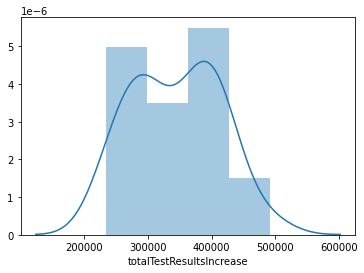

In [61]:
last_month = current_date - timedelta(days=30)
test_data_over_last_month = testing_data[testing_data['date'].between(last_month, current_date)]


seaborn.distplot(test_data_over_last_month["totalTestResultsIncrease"])

Now, we want to get this in a format where we can use it build a model. This will be useful later, when we want to repeat it in order to extrapolate what this could look like in August.

Since we're using `ergo`, this is easy: we just create a function that represents this field, which returns a random sample from the dataset. Then, to simulate the distribution of this field, we can sample from this function a large number of times. This is what the `show_marginal` function does, as well as plotting the resulting distribution.

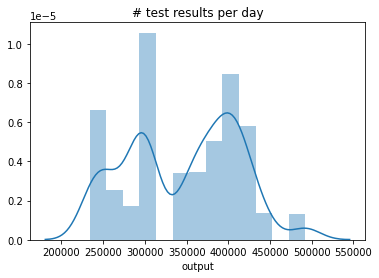

Median # test results per day: 362941.00 (240881.00 to 441248.00)


In [62]:
def test_results_increase_per_day():
    "# test results per day"
    return ergo.random_choice(list(test_data_over_last_month["totalTestResultsIncrease"]))

show_marginal(test_results_increase_per_day)


As a sanity check, this distribution looks very similar as plotting the distribution above, which makes sense as they should be equivalent since the above is just randomly sampling from the original.

## How much we can expect to change until August 1st?

### Repeating our current rates
Now, using our new `test_results_increase_per_day` function, can we extrapolate what the number of tests tomorrow could look like? One way to do this: 
- look at test results today, `current_test_number`
- sample from our `test_results_increase_per_day` distribution, add it to how many we have so far

Since `test_results_increase_per_day` returns a sample from this distribution, this just looks like adding `current_test_number` to `test_results_increase_per_day`.

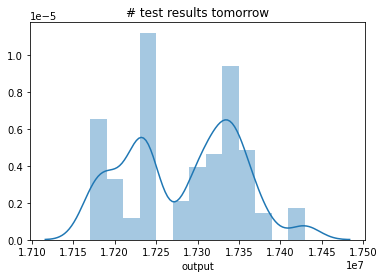

Median # test results tomorrow: 17299832.00 (17177772.00 to 17378139.00)


In [63]:
def test_results_tomorrow():
    "# test results tomorrow"
    return current_test_number + test_results_increase_per_day()

show_marginal(test_results_tomorrow)

Can we extend this to extrapolate further in the future? One simple way to do this (which we'll refine later): we can just increase the number of calls for ` test_results_increase_per_day()` for the number of days in the future we want. To verify this is working in a sensible way, let's test it for tomorrow:

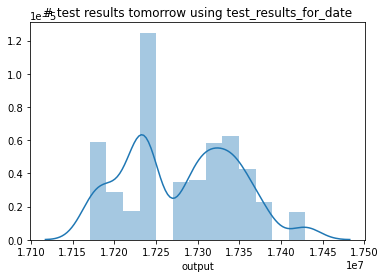

Median # test results tomorrow using test_results_for_date: 17289827.00 (17177772.00 to 17378139.00)


In [64]:
def test_results_for_date(date: datetime):
    number_of_days = (date - current_date).days
    return current_test_number + sum(test_results_increase_per_day() for _ in range(number_of_days))

def test_results_for_date_tomorrow():
    "# test results tomorrow using test_results_for_date"
    return test_results_for_date(current_date + timedelta(days=1))

show_marginal(test_results_for_date_tomorrow)


At least in my notebook, these show the exact same answer. So, now, if we want to predict for August, we can just change the date given.

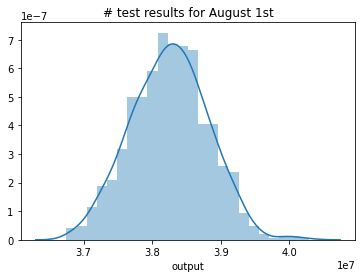

Median # test results for August 1st: 38260832.00 (37318765.50 to 39168690.80)


In [65]:
def test_results_for_deadline():
    "# test results for August 1st"
    return test_results_for_date(datetime(2020, 8, 1))

show_marginal(test_results_for_deadline)

### How much we can we expect our testing rates to change based on the past results?

The above analysis would work if the number of tests per day was mostly static. Let's validate that, and look at how the number of tests has changed over time. Apologies for the annoying x axis labels.

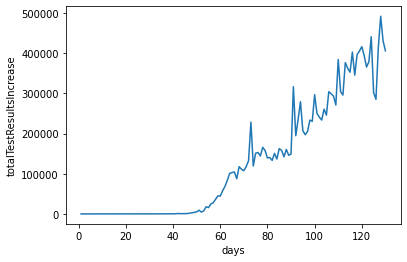

In [66]:
# create a days column, since that will help us make the x-axis look cleaner
first_date = testing_data["date"].min()
testing_data["days"] = \
    testing_data["date"].apply(lambda d: (d - first_date).days)

seaborn.lineplot(x="days", y="totalTestResultsIncrease", data=testing_data)

So we can see that roughly, month over month, the number of tests per day are increasing linearly. This means that our `test_results_for_deadline()` model above is probably underestimating the number of tests, as it's assuming the testing capacity remains static. 

What we want is to estimate the day over day increase, and use that to increase the number of tests our model is adding per day. Since it looks very linear right now, let's use a linear regression to estimate the slope of increases. We'll look at data when we past 100 000 cases, as that's where the trend seems to become linear.

In [67]:
# ignore early testing data, as it was mostly zero, then growing exponentially
test_data_worth_looking_at = testing_data[testing_data['totalTestResults'] >= 100000]

# do a linear regression using scipy
from scipy import stats
slope_of_test_increases = stats.linregress(test_data_worth_looking_at["days"], test_data_worth_looking_at["totalTestResultsIncrease"]).slope

slope_of_test_increases

5217.416616068123

Now, with this in hand, we can modify our previous estimate by using this slope. 

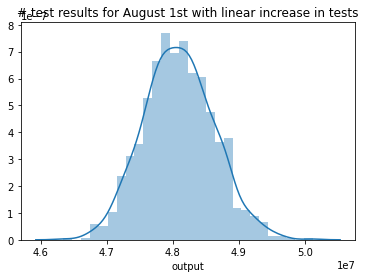

Median # test results for August 1st with linear increase in tests: 48077284.82 (47236910.22 to 48958529.87)


In [68]:
def test_results_for_date_with_slope(date: datetime):
    number_of_days = (date - current_date).days
    return current_test_number + sum(test_results_increase_per_day() + slope_of_test_increases * day for day in range(number_of_days))


def test_results_for_deadline_with_slope():
    "# test results for August 1st with linear increase in tests"
    return test_results_for_date_with_slope(datetime(2020, 8, 1))

show_marginal(test_results_for_deadline_with_slope)

### How much can we expect our testing rates to change, based on future factors?
Right now, our model is potentially a bit too overconfident. Testing might not increase linearly at this rate forever:
- we might increase testing rate, because of:
    - changes in testing policy to increase number of tests
    - outbreaks that intensify in regions
    - tests that are cheaper 
    - more infrastructure to deploy tests
    - etc.
- we might decrease testing rate, because of:
    - changes in testing policy to decrease the number of tests, to try understate the impact of the disease
    - containment strategies working well
    - hitting capacity limits on test manufacture
    - not being able to import any tests due to shortages in other countries
    - etc.

We could go down the rabbit hole of trying to predict each of these, but that would take a ton of time, and not necessarily change the prediction much. The cheaper time-wise thing to do is to try estimate how much we expect testing rates to change in the future. This is using the judgement based forecasting we mentioned above. 

I'm going to guess that linear growth is still possible until August, but that it could be anything from 0.25 to 2 current growth per day. I'm going to approximate this with a lognormal distribution, as I think that the most likely rate is around 1, but don't want to discount values at the tails.

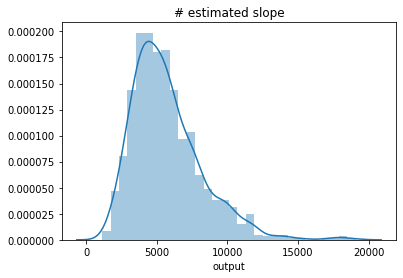

Median # estimated slope: 5240.84 (2644.24 to 10372.67)


In [69]:
def estimated_slope():
    "# estimated slope"
    return ergo.lognormal_from_interval(0.5, 2) * slope_of_test_increases

show_marginal(estimated_slope)

Now we can adapt our previous model, just using this estimated slope instead. 

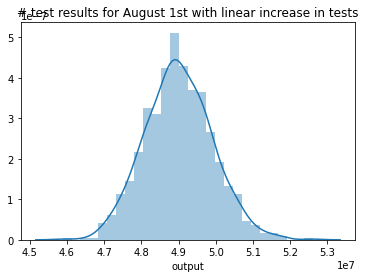

Median # test results for August 1st with linear increase in tests: 48970132.00 (47522792.80 to 50533805.80)


In [70]:
def test_results_for_date_with_slope(date: datetime):
    # The slightly more correct way of doing this would be to replace estimated_slope() * day with repeated calls
    # to estimated_slope. But as we're predicing kind of far into the future, this makes the simulation really slow.
    number_of_days = (date - current_date).days
    return current_test_number + sum(test_results_increase_per_day() + estimated_slope() * day for day in range(number_of_days))


def test_results_for_deadline_with_slope():
    "# test results for August 1st with linear increase in tests"
    return test_results_for_date_with_slope(datetime(2020, 8, 1))

show_marginal(test_results_for_deadline_with_slope)

# Incorporating the Metaculus prediction

Now that we have our own prediction, let's look at the Metaculus one. This will give us a sense of how our model stacks up to their community's model, and is a good sanity check to see if we missed something obvious. If you're running this notebook, remember to replace the credentials above with your own.

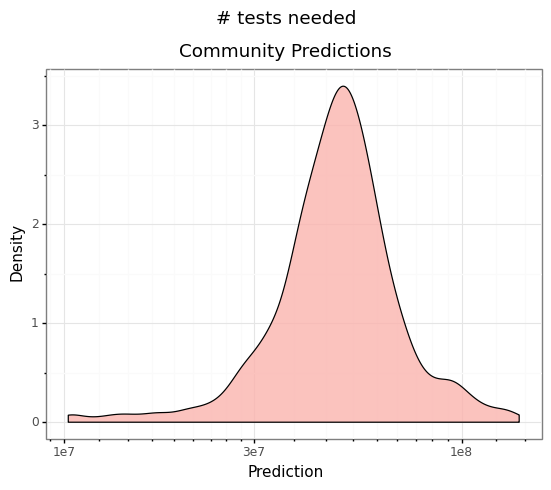

In [71]:
metaculus = ergo.Metaculus(username="oughtpublic", password="123456", api_domain="pandemic")
ventilators_question = metaculus.get_question(4400, name="# tests needed")
ventilators_question.show_community_prediction()

This is similar to our prediction, just less certain (longer tails) and centered slightly higher. Since I think they have valuable information I might have missed, I'm going to create a simple essemble prediction: pick randomly between a prediction the Metaculus community would make, and I would make, to create a combined model.

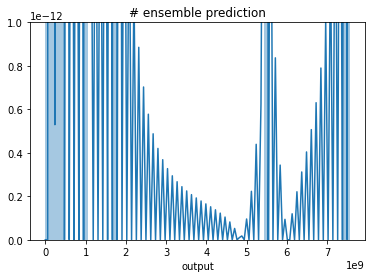

Median # ensemble prediction: 49094164.00 (29287881.30 to 80440128.00)


In [72]:
def ensemble_prediction():
    "# ensemble prediction"
    if ergo.flip(0.5):
        return ventilators_question.sample_community()
    else:
        return test_results_for_deadline_with_slope()

show_marginal(ensemble_prediction)

This shows a distribution similar to the one we had, just less certain, and with some probability for the long tails. 

# Submitting to metaculus

If we want to, we can now submit this model to Metaculus.

In [73]:
# below commented out to avoid accidentally submitting an answer when you don't mean to
# samples = ergo.run(ensemble_prediction, num_samples=1000)["output"]
# ventilators_question.submit_from_samples(samples)

# Summary
So create this model, we did the following:
- we fetched the latest data from https://covidtracking.com/
- estimated the growth of the number of tests to be a combination of the past linear growth, and a log-normal distribution
- used that to extrapolate the number of tests we'd have in August
- then combined that prediction with the metaculus prediction, to create a final forecast for number of tests on August 1st

Since we did a lot of iteration on our model, I'm including a cleaned up version of the entire thing below, so you can see everything at once.

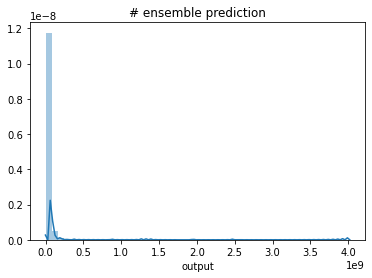

Median # ensemble prediction: 49116750.00 (30729974.00 to 84211824.00)


In [74]:
class Covid19TestsModel(object):
    def __init__(self, testing_data, ventilators_question):
        self.testing_data = testing_data
        self.ventilators_question = ventilators_question

        self.last_month = current_date - timedelta(days=30)
        self.current_date = testing_data["date"].max()
        # if there's multiple entries for a day for whatever reason, take the first
        self.current_test_number = testing_data.loc[testing_data["date"] == current_date]["totalTestResults"][0]
        
        # data subsets
        self.test_data_over_last_month = self.testing_data[testing_data['date'].between(last_month, current_date)]

        # calculate slope
        test_data_worth_looking_at = testing_data[testing_data['totalTestResults'] >= 100000]
        self.slope_of_test_increases = stats.linregress(
            test_data_worth_looking_at["days"], 
            test_data_worth_looking_at["totalTestResultsIncrease"]).slope
        
    def test_results_increase_per_day(self):
        """
        Estimated test increase over the past day looking at increases over the last month
        """
        return ergo.random_choice(list(self.test_data_over_last_month["totalTestResultsIncrease"]))
    
    def estimated_slope(self):
        """
        Estimated slope of increase of tests per day looking at linear regression of test cases,
        and a log-normal prediction of the possible changes
        """
        return ergo.lognormal_from_interval(0.5, 2) * self.slope_of_test_increases
    
    def test_results_for_date_with_slope(self, date: datetime):
        """
        Estimated test results for date, estimating based on the number of estimated test results per day
        including the estimated rate of increase
        """
        number_of_days = (date - self.current_date).days
        return self.current_test_number + \
            sum(self.test_results_increase_per_day() + self.estimated_slope() * day for day in range(number_of_days))


    def test_results_for_deadline_with_slope(self):
        return self.test_results_for_date_with_slope(datetime(2020, 8, 1))
    
    def ensemble_prediction(self):
        "# ensemble prediction"
        if ergo.flip(0.5):
            return self.ventilators_question.sample_community()
        else:
            return self.test_results_for_deadline_with_slope()

show_marginal(Covid19TestsModel(testing_data, ventilators_question).ensemble_prediction)

This hopefully shows why I like `ergo`: most of the code above is setting up the data. The actual building of the model, both extrapolating from the data and incorporating my estimates, is pretty succinct and (hopefully) simple.

If you want to make your own models, see the [ergo repo](https://github.com/oughtinc/ergo) for instructions on how ot get started, or just look at [some existing notebooks](https://github.com/oughtinc/ergo/tree/master/notebooks). 